<a href="https://colab.research.google.com/github/AnnyNny/population_classification/blob/main/Russian_population_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas
import zipfile
import urllib.request
import plotnine
from subprocess import Popen

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, log_loss, top_k_accuracy_score

import os, joblib, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

## Data Loading

### Archive data link

In [3]:
data_url = "http://www.russiangenome.ru/biengi.zip"
data_zip = os.path.join(data_dir, "plink_data.zip")

urllib.request.urlretrieve(data_url, data_zip)

('data/plink_data.zip', <http.client.HTTPMessage at 0x7a362f7ebb00>)

In [4]:
with zipfile.ZipFile(data_zip, 'r') as zipped_datafile:
    zipped_datafile.extractall(data_dir)

### Path to the data

In [5]:
data_prefix = [os.path.splitext(os.path.join(data_dir, file))[0] for file in os.listdir(data_dir) if file.endswith('.bed')][0]

In [6]:
import pandas as pd
snps = pd.read_csv("data/biengi.bim", sep="\t", header=None)
inds = pd.read_csv("data/biengi.fam", sep="\t", header=None)
print("Number of SNPs:", snps.shape[0])
print("Number of individuals:", inds.shape[0])


Number of SNPs: 242180
Number of individuals: 894


## Download plink

In [7]:
%%bash
URL64BIT="http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20200121.zip"
URL32BIT="http://s3.amazonaws.com/plink1-assets/plink_linux_i686_20200121.zip"

URL=$URL64BIT

wget -q $URL -O plink.zip
unzip -q -n plink.zip plink

## Functions for plink

In [8]:
def prune_data(plink_prefix, out_prefix):
    cmd = ['./plink', '--bfile', plink_prefix,
           '--indep', '50', '5', '2', '--out', out_prefix
    ]
    prune_result = out_prefix + '.prune.in'
    assert Popen(cmd).wait() == 0

    cmd = ['./plink', '--bfile', plink_prefix, '--extract', prune_result,
           '--make-bed', '--out', out_prefix
    ]
    assert Popen(cmd).wait() == 0

    return

def pca_plink(plink_prefix, out_prefix, n_components=20):
    # Perform PCA using plink
    cmd = ['./plink', '--pca', str(n_components), '--autosome']
    cmd += ['--bfile', plink_prefix, '--out', out_prefix]

    assert Popen(cmd).wait() == 0

    return out_prefix + '.eigenvec', out_prefix + '.eigenval'


## Pruning

In [9]:
pruned_data = data_prefix + '_pruned'
prune_data(data_prefix, pruned_data)

In [29]:
# Number of SNPs after pruning
!wc -l {pruned_data + '.bim'}

98602 data/biengi_pruned.bim


## PCA

In [10]:
pca_prefix = pruned_data + '_pruned'
pca_eigenvec, pca_eigenval = pca_plink(pruned_data, pca_prefix)

### Reading dependant variable (Population)

In [11]:
pop_filename = data_prefix + ".pedind"
pop_df = pandas.read_csv(pop_filename, sep="\s+", header=None, usecols = [0, 1, 5],
                        names=['FID', 'IID', 'Population'])

pop_df.head()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1471873661.py:2: SyntaxWarning: invalid escape sequence '\s'


,FID,IID,Population
0,4461875510_R01C01,4461875510_R01C01,Karel
1,4461875510_R01C02,4461875510_R01C02,Karel
2,4461875510_R02C01,4461875510_R02C01,Karel
3,4461875513_R02C02,4461875513_R02C02,Karel
4,4461875513_R01C02,4461875513_R01C02,Karel


### Reading PCA features

In [12]:
eigenvec_df = pandas.read_csv(pca_eigenvec, sep="\s+", header=None)
n_cols = eigenvec_df.shape[1]
pc_cols = [f"PC{i}" for i in range(1, n_cols-1)]
eigenvec_df.columns = ['FID', 'IID'] + pc_cols
eigenvec_df.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-905887647.py:1: SyntaxWarning: invalid escape sequence '\s'


,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,4461875510_R01C01,4461875510_R01C01,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,...,0.005069,0.051467,-0.010690,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613
1,4461875510_R01C02,4461875510_R01C02,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,...,-0.004695,-0.001433,-0.029270,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745
2,4461875510_R02C01,4461875510_R02C01,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,...,-0.000110,0.040661,-0.025415,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078
3,4461875513_R02C02,4461875513_R02C02,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,...,-0.013387,0.026770,-0.036955,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287
4,4461875513_R01C02,4461875513_R01C02,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,...,0.013590,0.035081,-0.020707,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286


In [13]:
print(pop_df.columns)
pop_df.head()


Index(['FID', 'IID', 'Population'], dtype='object')


,FID,IID,Population
0,4461875510_R01C01,4461875510_R01C01,Karel
1,4461875510_R01C02,4461875510_R01C02,Karel
2,4461875510_R02C01,4461875510_R02C01,Karel
3,4461875513_R02C02,4461875513_R02C02,Karel
4,4461875513_R01C02,4461875513_R01C02,Karel


In [14]:
merge_df = pandas.merge(eigenvec_df, pop_df, left_on=['FID', 'IID'], right_on=['FID', 'IID'])
merge_df.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Population
0,4461875510_R01C01,4461875510_R01C01,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,...,0.051467,-0.010690,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613,Karel
1,4461875510_R01C02,4461875510_R01C02,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,...,-0.001433,-0.029270,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745,Karel
2,4461875510_R02C01,4461875510_R02C01,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,...,0.040661,-0.025415,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078,Karel
3,4461875513_R02C02,4461875513_R02C02,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,...,0.026770,-0.036955,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287,Karel
4,4461875513_R01C02,4461875513_R01C02,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,...,0.035081,-0.020707,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286,Karel


In [15]:
df = merge_df.copy()

In [16]:
df.shape

(894, 23)

In [17]:
print("Unique groups:", len(df["Population"].unique()))
display(df["Population"].value_counts().head(30))

Unique groups: 28


,count
Population,
Kazakh,45
Tuva,44
Buryat,44
Yakut,41
Russian_STV,39
Uzbek,39
Russian_NSK,38
Megrel,36
Kabardin,35


In [18]:
group_means = df.groupby("Population")[pc_cols].mean()
group_means.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Population,,,,,,,,,,,,,,,,,,,,
Abkhaz,0.031622,-0.058212,-0.025333,0.001820,-0.009293,0.000351,-0.008472,0.005862,-0.007090,-0.001388,-0.001996,0.018928,-0.012499,0.003979,0.000028,0.005199,-0.048195,0.012164,-0.012510,0.006098
Adygei,0.028975,-0.046002,-0.020011,0.000782,-0.007429,0.002256,-0.008944,0.000190,-0.003817,0.006176,0.003824,0.052935,-0.050083,-0.026937,0.026526,-0.000534,0.087121,-0.012603,0.040026,-0.011629
Bashkir,-0.010871,0.011574,-0.003718,0.025520,0.011755,-0.003960,0.021061,-0.018722,0.033408,0.062173,0.008364,-0.080397,-0.096146,0.001719,0.013439,0.016117,-0.020704,-0.005900,-0.000484,-0.001712
Belarus,0.032647,0.031262,0.028757,-0.024642,-0.000169,0.021173,0.000089,0.001374,0.019796,-0.032334,-0.003422,-0.006903,-0.002071,-0.003249,0.014625,-0.002380,0.012466,0.007616,-0.003407,0.014309
Buryat,-0.054696,-0.014267,0.033180,0.000186,0.029031,0.006437,-0.116379,-0.013238,0.007579,0.002068,0.003087,-0.001520,0.003887,0.002336,0.001774,0.004207,-0.000016,0.000837,-0.000811,0.000451


## Plot two main PCs

In [19]:
import numpy as np
import pandas as pd
eigvals = pd.read_csv("/content/data/biengi_pruned_pruned.eigenval", header=None)
var_explained = eigvals[0] / eigvals[0].sum()
print("PC1:", var_explained.iloc[0], "PC2:", var_explained.iloc[1])
print("Cumulative (PC1 + PC2):", var_explained.iloc[:2].sum())


PC1: 0.43140156000375907 PC2: 0.09913850202048681
Cumulative (PC1 + PC2): 0.5305400620242459


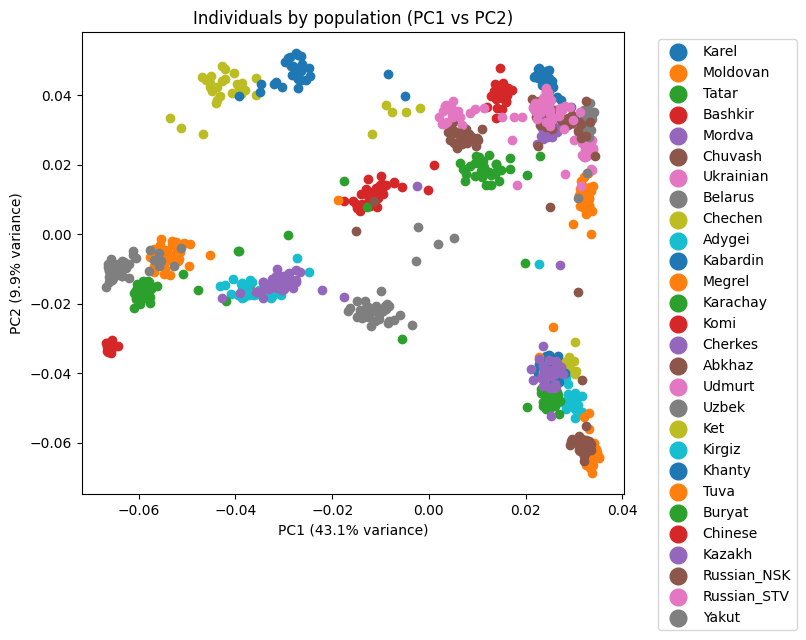

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
populations = df["Population"].unique()
for pop in populations:
    sub = df[df["Population"] == pop]
    plt.scatter(
        sub["PC1"],
        sub["PC2"],
        label=pop
    )

plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel(f"PC1 ({var_explained.iloc[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({var_explained.iloc[1]*100:.1f}% variance)")
plt.title("Individuals by population (PC1 vs PC2)")
plt.show()

### Model Learning

In [22]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, log_loss, top_k_accuracy_score


X = df[pc_cols].values
y = df["Population"].values


le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB()
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    print(f"{name}: mean accuracy = {scores.mean():.3f} ± {scores.std():.3f}")


LogisticRegression: mean accuracy = 0.404 ± 0.036
RandomForest: mean accuracy = 0.856 ± 0.024
SVM: mean accuracy = 0.814 ± 0.024
KNN: mean accuracy = 0.811 ± 0.026
NaiveBayes: mean accuracy = 0.820 ± 0.027


Notice that LogisticRegression model is much less accurate, this happens because the first principal component responsible for the most variance in the dataset is outweighing other PCs. To correct it, Standard Scaler is applied.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="accuracy")
    print(f"{name}: mean accuracy = {scores.mean():.3f} ± {scores.std():.3f}")


Accuracy (takes into account only recall) and F1-macro (averaged recall and precision) score are the highest for RandomForest model.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1_macro")
    print(f"{name}: mean F1-score = {scores.mean():.3f} ± {scores.std():.3f}")


### Parameter Tuning

In [ ]:
# tune the parameters to choose the optimal ones using stratified cross-validation

import os, joblib, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             log_loss, top_k_accuracy_score)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "balanced_accuracy"


# hyperparameter spaces
models = {
    # Linear baselines
    "LogReg":  (LogisticRegression(max_iter=5000, multi_class="multinomial", solver="lbfgs"),
                {"C": [0.3, 1, 3, 10]}),
    "SVM_rbf": (SVC(kernel="rbf", probability=True, random_state=42),
                {"C": [0.3, 1, 3, 10], "gamma": ["scale", 0.1, 0.03, 0.01]}),
    "KNN":     (KNeighborsClassifier(),
                {"n_neighbors": [5, 9, 15, 25], "weights": ["uniform", "distance"]}),
    "GaussianNB": (GaussianNB(),
                   {"var_smoothing": [1e-9, 3e-9, 1e-8, 3e-8, 1e-7]}),

    # Trees
    "RandomForest": (RandomForestClassifier(random_state=42, n_jobs=-1),
                     {"n_estimators": [200, 400],
                      "max_depth": [None, 20],
                      "min_samples_leaf": [1, 2],
                      "min_samples_split": [2, 5],
                      "max_features": ["sqrt", "log2", 0.5],
                      "class_weight": [None, "balanced_subsample"]}),

    "AdaBoost": (AdaBoostClassifier(random_state=42),
                 {"n_estimators": [100, 200], "learning_rate": [0.5, 1.0]})
}


cv_results_list = []
best_models = {}

os.makedirs("tuned_models", exist_ok=True)

for name, (estimator, grid) in models.items():
    print(f"\n=== Tuning {name} ===")
    gs = GridSearchCV(estimator, grid, scoring=scoring, cv=cv,
                      n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_train_scaled, y_train)
    best = gs.best_estimator_
    cv_ba = gs.best_score_
    pd.DataFrame(gs.cv_results_).to_csv(f"tuned_models/{name}_cv_results.csv", index=False)
    print("best params:", gs.best_params_, "cv Balanced Accuracy:", cv_ba)
    best_models[name] = best
    cv_results_list.append({"name": name, "cv_ba": float(cv_ba), "best": best})


cv_results_list = [d for d in cv_results_list if not np.isnan(d["cv_ba"])]
top3 = sorted(cv_results_list, key=lambda d: d["cv_ba"], reverse=True)[:3]
print("\nTop-3 by CV BA:")
for d in top3:
    print(f"  {d['name']}: CV BA={d['cv_ba']:.3f}")



## Evaluate the best model on Test Data

In [ ]:
# evaluate top-3 on test
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             log_loss, top_k_accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

test_rows = []
for d in top3:
    name = d["name"]
    model = d["best"]

    y_pred = model.predict(X_test_scaled)
    has_proba = hasattr(model, "predict_proba")
    y_proba = model.predict_proba(X_test_scaled) if has_proba else None

    acc  = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")
    ll   = log_loss(y_test, y_proba) if has_proba else np.nan
    top2 = top_k_accuracy_score(y_test, y_proba, k=2) if has_proba else np.nan

    print(f"\n=== TEST metrics for {name} ===")
    print(f"Accuracy:          {acc:.3f}")
    print(f"Balanced Accuracy: {bacc:.3f}")
    print(f"Macro-F1:          {f1m:.3f}")
    if has_proba:
        print(f"LogLoss:           {ll:.3f}")
        print(f"Top-2 Accuracy:    {top2:.3f}")

    missing = set(np.unique(y_test)) - set(np.unique(y_pred))
    if missing:
        print(f"This classes were not predicted at all by {name} model:", missing)

    # save report + confusion matrix for each top model
    rep = classification_report(y_test, y_pred, digits=3)
    with open(f"tuned_models/{name}_TEST_report.txt", "w") as f:
        f.write(rep)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(include_values=False, xticks_rotation=90)
    plt.tight_layout()
    plt.savefig(f"tuned_models/{name}_TEST_confusion_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    test_rows.append({
        "model": name,
        "cv_balanced_accuracy": d["cv_ba"],
        "test_accuracy": acc,
        "test_balanced_accuracy": bacc,
        "test_macro_f1": f1m,
        "test_log_loss": ll,
        "test_top2_accuracy": top2
    })



In [ ]:
top3_table = pd.DataFrame(test_rows).sort_values("test_macro_f1", ascending=False)
top3_table.to_csv("tuned_models/top3_test_metrics.csv", index=False)

In [ ]:
print("\nTop-3 on Test:")
print(top3_table.to_markdown(index=False, tablefmt="github"))